In [1]:
import pandas as pd
import sqlite3

from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from quantile_forest import RandomForestQuantileRegressor

import pickle

## Training Data: 2014-24 Free Agent Data + Stats + Advanced Stats

### Load Data

In [2]:
con = sqlite3.connect('nba_data.db')
train = pd.read_sql_query('SELECT * FROM FA_FULL_cleaned', con)
con.close()

### Transform Data

In [3]:
train = train.drop(columns = ['OWS', 'DWS', 'OBPM', 'DBPM',
                              'Season', 'MPG', 'ID', 'WS/48'])
train = train.rename(columns={'Name': 'Player', 'Age_x': 'AGE', 'PPG': 'PTS',
                              'APG': 'AST', 'RPG': 'TRB', 'SPG': 'STL',
                              'BPG': 'BLK', 'Pos': 'POS'})

In [4]:
# Solving a Scraping Error
train.loc[(train['PTS'] < 8) & (train['Contract'] > 30000000), 'Contract'] = train.loc[(train['PTS'] < 8) & (train['Contract'] > 30000000), 'Contract'] / 4

In [5]:
train.loc[(train['Contract'] > 30000000), :].sort_values('PTS')

,level_0,index,Player,FA_Year,Contract,AGE,eFG,PTS,AST,TRB,STL,BLK,is_AllStar,is_AllNBA,POS,WS,BPM,VORP
201,272,63,Khris Middleton,2023,3.400000e+07,31.0,0.498768,15.060606,4.939394,4.242424,0.696970,0.151515,0.0,0.0,SF,1.9,0.8,0.6
315,395,186,Deandre Ayton,2022,3.325000e+07,23.0,0.639168,17.189655,1.448276,10.224138,0.689655,0.689655,0.0,0.0,C,7.3,2.8,2.1
53,81,48,Paul Millsap,2017,3.011667e+07,32.0,0.480967,18.057971,3.652174,7.724638,1.304348,0.898551,1.0,0.0,PF,6.4,2.1,2.4
270,347,138,Fred VanVleet,2023,4.333333e+07,29.0,0.486061,19.347826,7.173913,4.057971,1.782609,0.550725,0.0,0.0,PG,6.5,2.5,2.9
232,305,96,Jerami Grant,2023,3.200000e+07,29.0,0.554217,20.476190,2.380952,4.492063,0.809524,0.841270,0.0,0.0,PF,4.1,-0.2,1.0
59,91,116,Gordon Hayward,2017,3.121430e+07,27.0,0.535900,21.931507,3.452055,5.397260,1.000000,0.273973,1.0,0.0,SF,10.4,5.0,4.5
168,237,28,James Harden,2022,3.430000e+07,32.0,0.484879,22.030769,10.261538,7.692308,1.261538,0.553846,0.0,0.0,PG,7.6,4.0,3.7
26,34,17,Kyle Lowry,2017,3.163333e+07,31.0,0.569172,22.400000,6.950000,4.766667,1.466667,0.316667,1.0,0.0,PG,10.1,6.1,4.6
193,264,55,Bradley Beal,2022,5.020000e+07,29.0,0.492218,23.200000,6.625000,4.725000,0.900000,0.375000,0.0,0.0,SG,1.4,0.8,1.0
72,108,71,Russell Westbrook,2016,3.016817e+07,27.0,0.489266,23.475000,10.425000,7.825000,2.037500,0.250000,1.0,1.0,PG,14.0,7.8,6.8


## Testing Data: Scraped 2024 Free Agents

### Load Data

In [6]:
test = pd.read_csv('./raw_data/rough.csv')

### Clean Data

In [7]:
test = test.dropna()
test = test.drop(columns=['PER', 'USG.'])
test = test.rename(columns={'eFG.': 'eFG'})

### Transform Data

In [8]:
test['FA_Year'] = 2024

In [9]:
test_new = test.drop(columns = ['Player', 'PREV_CONT'])

# Obtain the dummy variables for various POS
test_new = pd.get_dummies(test_new)

## Exploratory Data Analysis

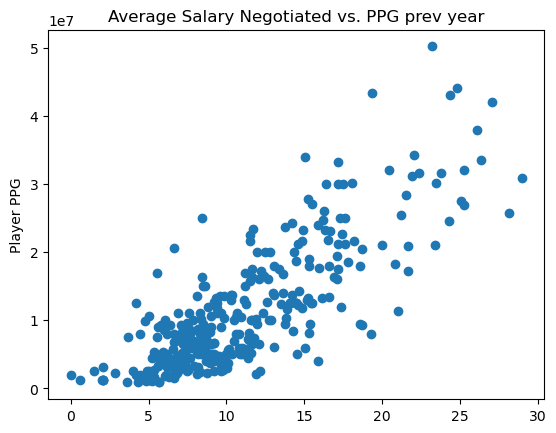

In [10]:
# Scatter Plot of PTS vs Salary
plt.scatter(train['PTS'], train['Contract'])
plt.title('Average Salary Negotiated vs. PPG prev year')
plt.ylabel('Salary (per $10M)')
plt.ylabel('Player PPG')
plt.show()

### Figure 1

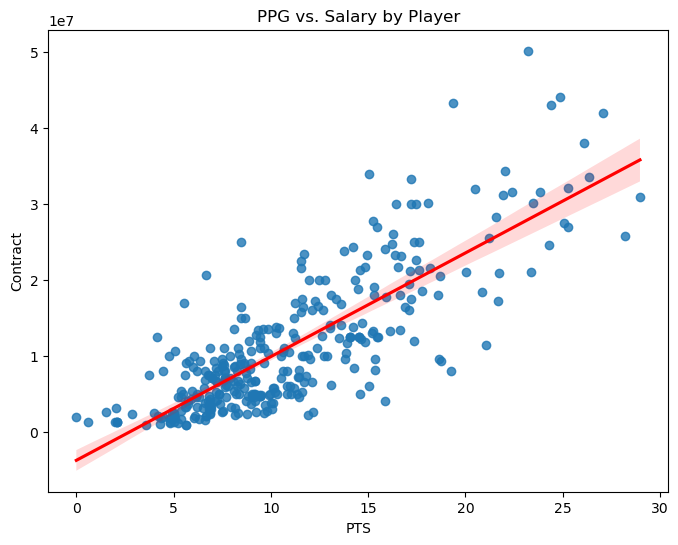

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.regplot(
    x=train["PTS"],
    y=train["Contract"],
    line_kws={"color": "r"},
    ax=ax
).set(title = "PPG vs. Salary by Player")
plt.show()

In [12]:
pearsonr(train['PTS'], train['Contract'])

PearsonRResult(statistic=0.8091635586063995, pvalue=9.533810888721647e-81)

### Figure 2

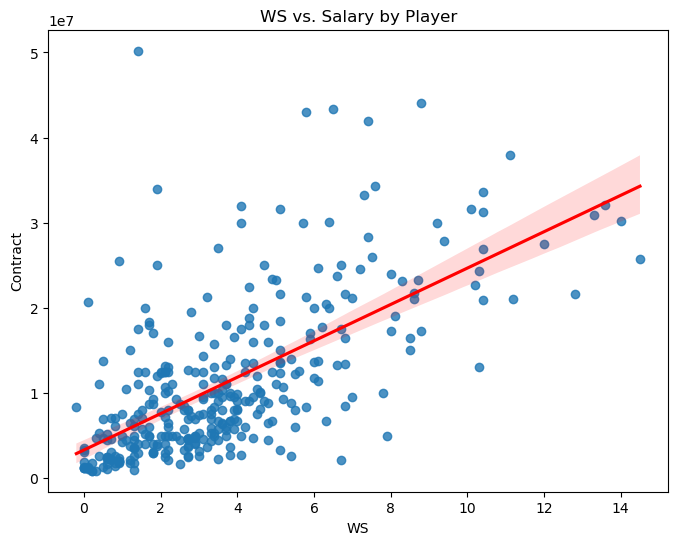

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.regplot(
    x=train["WS"],
    y=train["Contract"],
    line_kws={"color": "r"},
    ax=ax
).set(title = "WS vs. Salary by Player")
plt.show()

In [14]:
pearsonr(train['WS'], train['Contract'])

PearsonRResult(statistic=0.6523651497137952, pvalue=5.856830433868294e-43)

### Figure 3

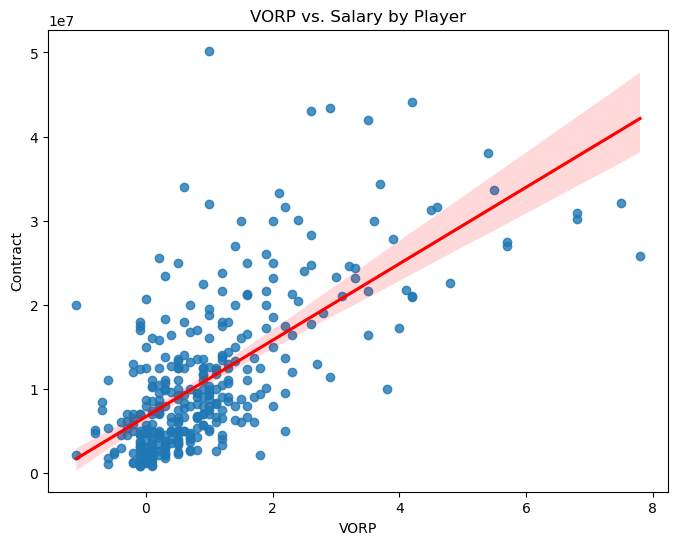

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.regplot(
    x=train["VORP"],
    y=train["Contract"],
    line_kws={"color": "r"},
    ax=ax
).set(title = "VORP vs. Salary by Player")
plt.show()

In [16]:
pearsonr(train['VORP'], train['Contract'])

PearsonRResult(statistic=0.6795161501366077, pvalue=8.618522113300412e-48)

### Figure 4

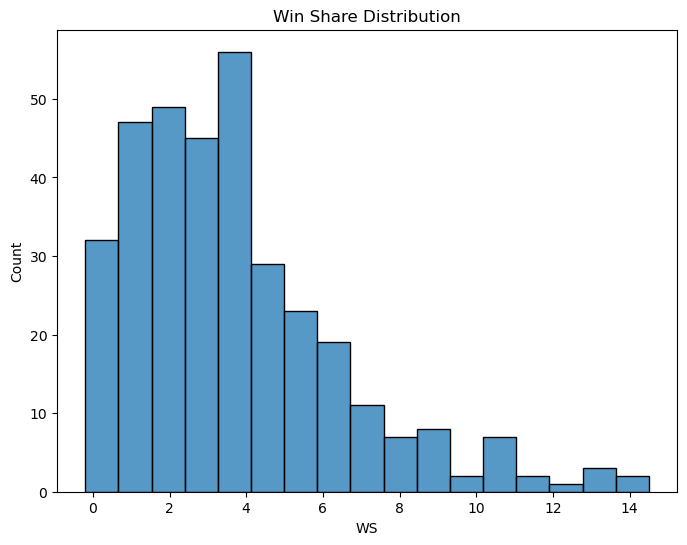

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(train['WS']).set(title = "Win Share Distribution")
plt.show()

### Figure 5

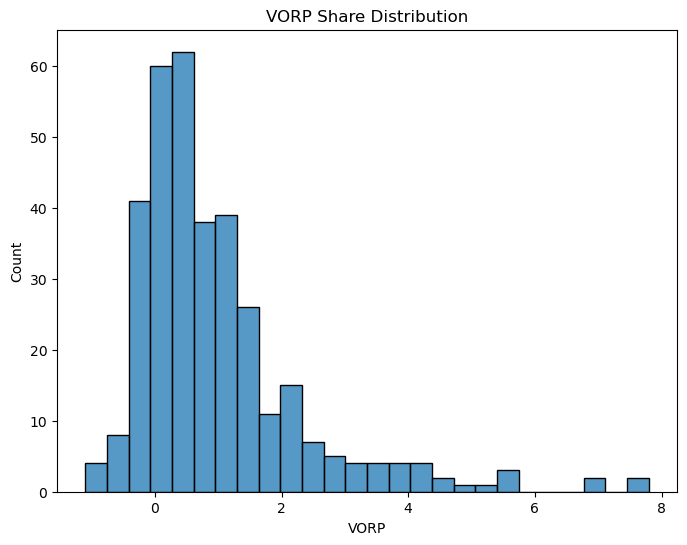

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(train['VORP']).set(title = "VORP Share Distribution")
plt.show()

### Non-Used Plots

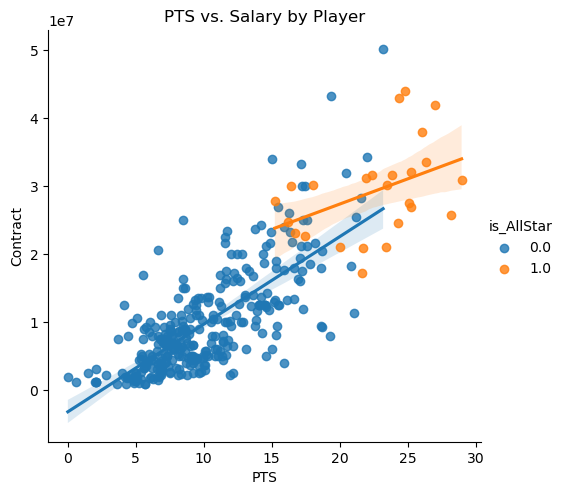

In [19]:
sns.lmplot(
    x="PTS",
    y="Contract",
    data = train,
    hue='is_AllStar'
).set(title = "PTS vs. Salary by Player")
plt.show()

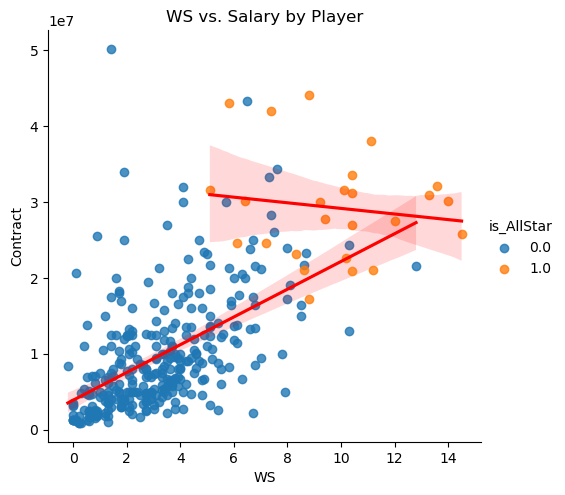

In [20]:
# fig, ax = plt.subplots(figsize=(8, 6))
sns.lmplot(
    x="WS",
    y="Contract",
    data = train,
    line_kws={"color": "r"},
    hue='is_AllStar'
).set(title = "WS vs. Salary by Player")
plt.show()

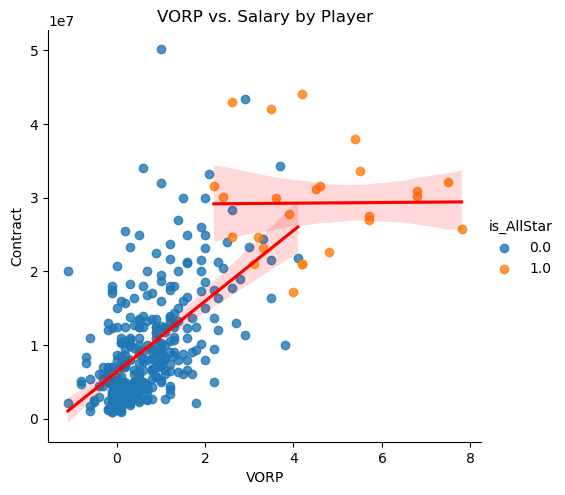

In [21]:
sns.lmplot(
    x="VORP",
    y="Contract",
    data = train,
    line_kws={"color": "r"},
    hue='is_AllStar'
).set(title = "VORP vs. Salary by Player")
plt.show()

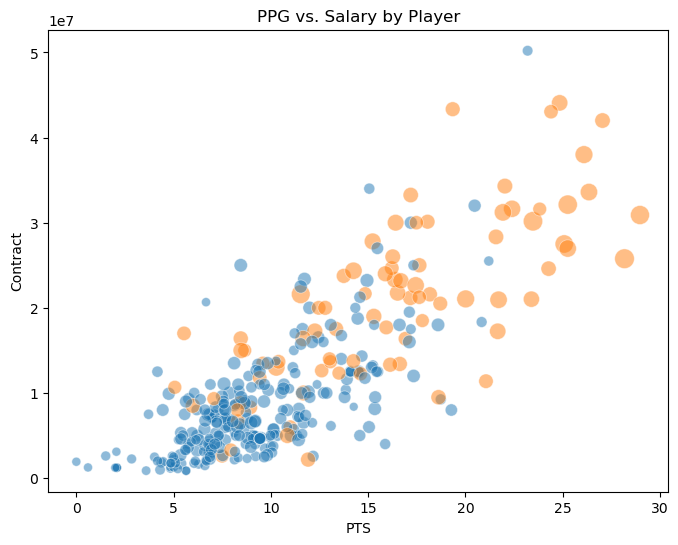

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(
    x=train["PTS"],
    y=train["Contract"],
    ax=ax,
    size=train["WS"],
    sizes=(40, 200),
    hue = train["WS"]>5,
    alpha=.5,
    legend = False
).set(title = "PPG vs. Salary by Player")
# plt.legend(title='WS>5', loc='upper left', labels=['False', 'True'])
plt.show()

## Model Training

In [23]:
# Make the Training Dataset ready for model consumption
train_new = train.drop(columns = ['Player', 'index', 'level_0'])
train_new = pd.get_dummies(train_new)
X = train_new.drop(columns = ['Contract'])
y = train_new['Contract']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state = 42)

### Random Forest Regressor on Whole Training Dataset

In [24]:
clf = RandomForestRegressor(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [25]:
importances = clf.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': X_train.columns, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df.head())

    Feature  Gini Importance
3       PTS         0.660075
10       WS         0.062878
12     VORP         0.046958
4       AST         0.042076
0   FA_Year         0.033461


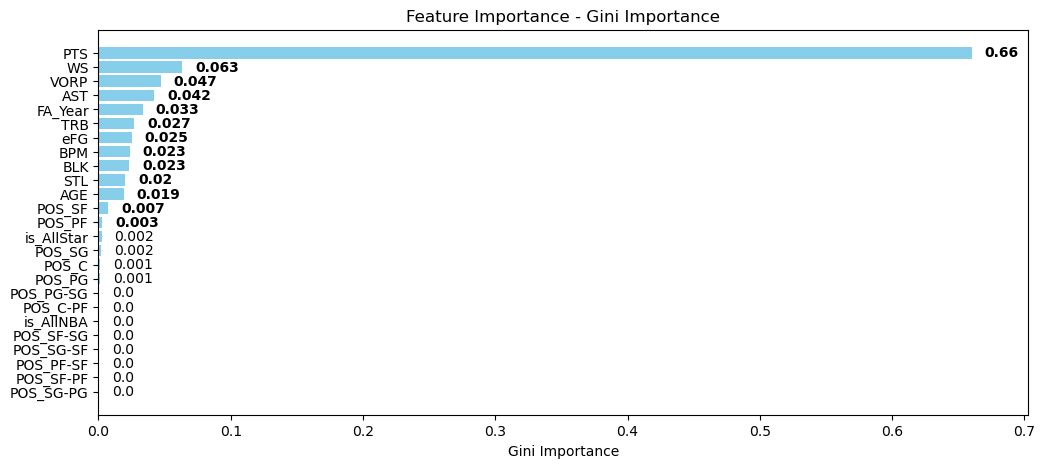

In [26]:
# Create a bar plot for feature importance
fig, ax = plt.subplots(figsize=(12,5))
ax.barh(feature_imp_df['Feature'], feature_imp_df['Gini Importance'], color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
_, xmax = plt.xlim()
plt.xlim(0, xmax + 0.01)
for i, v in enumerate(round(feature_imp_df['Gini Importance'], 3)):
    if i <= 12:
        ax.text(v + 0.01, i, str(v), color='black', fontweight='bold', fontsize=10, ha='left', va='center')
    else:
        ax.text(v + 0.01, i, str(v), color='black', fontsize=10, ha='left', va='center')
plt.show()

Listed above are the features deemed most important from a RandomForestRegressor. We will use this narrowed down dataset to build models for prediction.

### Perform Feature Selection

In [27]:
# Using a random forest regressor and obtaining the best features via the median metric.
select = SelectFromModel(
    RandomForestRegressor(n_estimators=100, random_state=42),
    threshold="median")

# What is the feature shape
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

# what are the features that will be left from feature selection
select.get_feature_names_out()

X_train.shape: (240, 25)
X_train_l1.shape: (240, 13)


array(['FA_Year', 'AGE', 'eFG', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'WS',
       'BPM', 'VORP', 'POS_PF', 'POS_SF'], dtype=object)

### The new smaller data frame

In [28]:
X = train_new[select.get_feature_names_out()]
# X = X.drop(columns = ['FA_Year'])
test_X_new = test_new[select.get_feature_names_out()]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state = 42)

### Random Forest Regressor on Feature Selected Dataset

In [29]:
forest = RandomForestRegressor(n_estimators = 500, max_depth = 3, random_state=42)
forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, n_estimators=500, random_state=42)

#### Scores

In [30]:
print(f"Training Score: {round(forest.score(X_train, y_train), 2)}")
print(f"Testing Score: {round(forest.score(X_test, y_test), 2)}")
print(f"RMSE: {round(mean_squared_error(y_test, forest.predict(X_test)) ** 0.5, 2)}")

Training Score: 0.82
Testing Score: 0.63
RMSE: 5147805.4


#### Feature Importance

In [31]:
importance = forest.feature_importances_
columns_names = list(X_train.columns)
importance_sorted_list = sorted(zip(importance ,columns_names), reverse=True)
for v in (importance_sorted_list):
    print(f"{v[1]} - Score: {round(v[0], 3)}")

PTS - Score: 0.784
WS - Score: 0.058
VORP - Score: 0.047
AST - Score: 0.03
FA_Year - Score: 0.024
BPM - Score: 0.017
TRB - Score: 0.013
BLK - Score: 0.006
AGE - Score: 0.006
eFG - Score: 0.006
STL - Score: 0.005
POS_SF - Score: 0.004
POS_PF - Score: 0.0


### Gradient Boosting Regressor

In [32]:
gbrt = GradientBoostingRegressor(random_state=0, max_depth = 2, learning_rate=0.01, n_estimators=1000)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=2, n_estimators=1000,
                          random_state=0)

#### Scores

In [33]:
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train,y_train)))
print("Accuracy on testing set: {:.3f}".format(gbrt.score(X_test,y_test)))
print("RMSE: {:.3f}".format(mean_squared_error(y_test, gbrt.predict(X_test)) ** 0.5))

Accuracy on training set: 0.921
Accuracy on testing set: 0.605
RMSE: 5329563.000


### Feature Importance

In [34]:
importance = gbrt.feature_importances_
columns_names = list(X_train.columns)
importance_sorted_list = sorted(zip(importance ,columns_names), reverse=True)
for v in (importance_sorted_list):
    print(f"{v[1]} - Score: {round(v[0], 3)}")

PTS - Score: 0.627
WS - Score: 0.111
VORP - Score: 0.065
FA_Year - Score: 0.061
AST - Score: 0.053
TRB - Score: 0.025
STL - Score: 0.018
BLK - Score: 0.018
eFG - Score: 0.01
AGE - Score: 0.005
POS_SF - Score: 0.003
POS_PF - Score: 0.003
BPM - Score: 0.001


### Linear Regression

In [35]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

#### Scores

In [36]:
print("Accuracy on training set: {:.3f}".format(lr.score(X_train,y_train)))
print("Accuracy on testing set: {:.3f}".format(lr.score(X_test,y_test)))
print("RMSE: {:.3f}".format(mean_squared_error(y_test, lr.predict(X_test)) ** 0.5))

Accuracy on training set: 0.752
Accuracy on testing set: 0.580
RMSE: 5500777.980


## Best Model

In [37]:
forest = RandomForestRegressor(n_estimators = 500, max_depth = 3, random_state=42)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train,y_train)))
print("Accuracy on testing set: {:.3f}".format(forest.score(X_test,y_test)))
print("RMSE: {:.3f}".format(mean_squared_error(y_test, forest.predict(X_test)) ** 0.5))

Accuracy on training set: 0.816
Accuracy on testing set: 0.632
RMSE: 5147805.398


### Predict on 2024 Free Agents

In [38]:
preds = forest.predict(test_X_new)

In [39]:
test['EXPECTED_CONT'] = preds

### Get Predictions at Various Quantiles

In [40]:
qrf = RandomForestQuantileRegressor(n_estimators = 500, max_depth = 3, random_state=42)

qrf.fit(X_train, y_train)

RandomForestQuantileRegressor(max_depth=3, n_estimators=500, random_state=42)

In [41]:
qrf.score(X_train, y_train)
qrf.score(X_test, y_test)

/Users/joshuali/opt/anaconda3/envs/PIC16B/lib/python3.8/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/joshuali/opt/anaconda3/envs/PIC16B/lib/python3.8/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


0.649763396168676

In [42]:
y_pred = qrf.predict(test_X_new, quantiles=[0.025, 0.5, 0.975])

/Users/joshuali/opt/anaconda3/envs/PIC16B/lib/python3.8/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


## Experimenting with Models

In [43]:
all_models = {}
common_params = dict(
    n_estimators = 500,
    max_depth= 3,
    random_state= 42
)
for alpha in [0.05, 0.5, 0.75, 0.95]:
    qrf = RandomForestQuantileRegressor(**common_params)
    all_models["q %1.2f" % alpha] = qrf.fit(X_train, y_train)

In [44]:
y_lower = all_models['q 0.05'].predict(test_X_new, quantiles=[0.05])
y_3rd = all_models['q 0.75'].predict(test_X_new, quantiles = [0.75])
y_upper = all_models['q 0.95'].predict(test_X_new, quantiles=[0.95])

/Users/joshuali/opt/anaconda3/envs/PIC16B/lib/python3.8/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/joshuali/opt/anaconda3/envs/PIC16B/lib/python3.8/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/joshuali/opt/anaconda3/envs/PIC16B/lib/python3.8/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


### Save Best Models

In [45]:
# save
with open('./models/best_model.pkl','wb') as f:
    pickle.dump(forest,f)
    
with open('./models/best_model_3rd.pkl', 'wb') as f:
    pickle.dump(all_models['q 0.95'], f)

In [46]:
test['LOWER_LIMIT'] = y_lower
test['UPPER_LIMIT'] = y_3rd

In [47]:
final_test_DF = test.sort_values('EXPECTED_CONT', ascending=False)

### Export the Test Predictions to a CSV

In [48]:
final_test_DF.to_csv('./output/test_preds.csv')
final_test_DF.head(10)

,Player,eFG,TRB,AST,STL,BLK,PTS,WS,BPM,VORP,POS,AGE,PREV_CONT,FA_Year,EXPECTED_CONT,LOWER_LIMIT,UPPER_LIMIT
129,LeBron James,0.599,7.3,8.3,1.3,0.5,25.7,8.5,6.5,5.4,PF,39.4,"$49,511,644.00",2024,3.450403e+07,2.696698e+07,42000000.0
205,Tyrese Maxey,0.524,3.7,6.2,1.0,0.5,25.9,8.1,3.1,3.4,PG,23.6,"$3,038,140.00",2024,3.257007e+07,1.798497e+07,42000000.0
44,DeMar DeRozan,0.507,4.3,5.3,1.1,0.6,24.0,9.2,1.8,2.8,SF,34.8,"$27,300,000.00",2024,3.235658e+07,1.800000e+07,38000000.0
169,Paul George,0.569,5.2,3.5,1.5,0.5,22.6,7.3,3.2,3.3,SG,34.1,"$44,066,367.00",2024,3.135184e+07,1.800000e+07,34300000.0
84,James Harden,0.541,5.1,8.5,1.1,0.8,16.6,8.4,4.1,3.8,SG,34.8,"$34,320,000.00",2024,2.947339e+07,1.748875e+07,34000000.0
165,Pascal Siakam,0.569,7.1,4.3,0.8,0.3,21.7,6.9,1.9,2.7,PF,30.2,"$34,226,304.00",2024,2.792495e+07,1.724486e+07,32124579.5
148,Miles Bridges,0.527,7.3,3.3,0.9,0.5,21.0,2.2,-1.1,0.6,SF,26.2,"$7,921,300.00",2024,2.246387e+07,1.138081e+07,27500000.0
198,Tobias Harris,0.535,6.5,3.1,1.0,0.7,17.2,5.9,0.9,1.7,PF,31.8,"$36,000,000.00",2024,2.213423e+07,1.138081e+07,25500000.0
30,D'Angelo Russell,0.560,3.1,6.3,0.9,0.5,18.0,5.1,0.9,1.8,PG,28.2,"$18,000,000.00",2024,2.207192e+07,1.138081e+07,25500000.0
69,Immanuel Quickley,0.530,3.8,4.9,0.7,0.1,17.0,4.7,1.3,1.7,PG,24.9,"$2,700,987.00",2024,2.117240e+07,1.161279e+07,25000000.0
